In [3]:
# Processing experiments around the ROI 
# coding: utf-8

import sys
import os

from pprint import pprint
from collections import OrderedDict

sys.path.insert(0, './src/')

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

from IPython.display import HTML
from scipy import ndimage

from FRAPanalyzer.lifproc import LIFContainer
from FRAPanalyzer.lifproc import start_bioformats
from FRAPanalyzer.lifproc import stop_bioformats
from processing import Processing, win_gaus, win_average

Opening wrapper for bioformats

In [4]:
start_bioformats()

BioContainer started


Loading experiment *.lif* file

In [8]:
lif = LIFContainer('./test_data/Experiment_001.lif')

IOError: [Errno 2] The file, "./test_data/Experiment_001.lif", does not exist.: './test_data/Experiment_001.lif'

Looking for a structure in wrapped object

In [4]:
lif.lif_img_data

OrderedDict([('Image005',
              {'C': 3, 'ID': 'Image:0', 'T': 1, 'X': 512, 'Y': 512, 'Z': 1}),
             ('FRAP/FRAP Series09',
              {'C': 2, 'ID': 'Image:1', 'T': 127, 'X': 128, 'Y': 128, 'Z': 1}),
             ('FRAP_004/FRAP Series16',
              {'C': 1, 'ID': 'Image:2', 'T': 369, 'X': 64, 'Y': 64, 'Z': 1}),
             ('FRAP/FRAP Series18',
              {'C': 1, 'ID': 'Image:3', 'T': 787, 'X': 64, 'Y': 64, 'Z': 1})])

Selecting series of images

In [5]:
series_id = 'FRAP_004/FRAP Series16'

Loading images to numpy array

In [6]:
img = lif.get_full_array(series_id, progressbar=True)

100%|██████████| 369/369 [00:24<00:00, 15.00it/s]


In [8]:
# img = wrp.get_full_array('FRAP_001/FRAP Series10')
# series_name = 'FRAP_001/FRAP Series10'
print(lif.lif_img_data[series_id])
current_series_id = lif.lif_series_order.index(series_id)

{'C': 1, 'T': 369, 'Y': 64, 'X': 64, 'Z': 1, 'ID': 'Image:2'}


In [15]:
rois_struc = lif.get_rois_from_oemxml()

In [17]:
poly = rois_struc['ROI:1'][1]['Polygon']

In [19]:
img = img[:,:,0,:] # 100]

In [20]:
img.shape

(64, 64, 369)

<IPython.core.display.Javascript object>


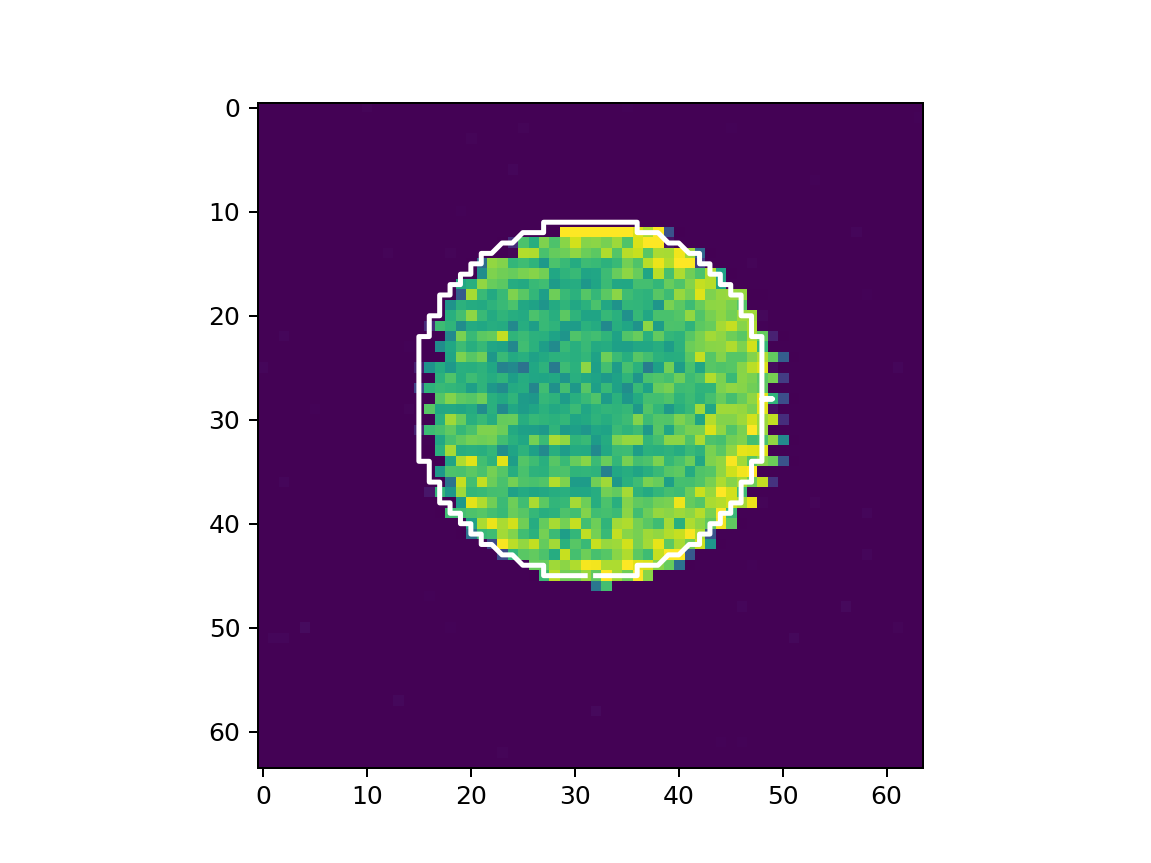

(369,) (369,)


In [21]:
# prebleach 0-1, bleach 1 - 60 , after-bleach 61 - 

# contour around the ROI
# just int value contour

t = 60
fig = plt.figure()
plt.imshow(img[:,:,t])
x0, y0 = 32.0, 28.5
# x0, y0 = rois_struc['ROI:0'][0]['X'], rois_struc['ROI:0'][0]['Y']
R = 17
t = np.linspace(0, np.pi * 2, 369)
x = x0 + R*np.sin(t)
y = y0 + R*np.cos(t)

x = np.array([int(e) for e in x])
y = np.array([int(e) for e in y])

# print x.shape, y.shape
# print x

plt.plot(x,y,color='w', linewidth=2.0);

Applying sobel filters to images

In [22]:
from skimage.filters import (sobel_h, sobel_v)

sh_frames = np.zeros(img.shape[:2] + (39,))
sv_frames = np.zeros(img.shape[:2] + (39,))

for i in range(61,100):
    sh_frames[:,:,i - 61] = sobel_h(img[:,:,i])
    sv_frames[:,:,i - 61] = sobel_v(img[:,:,i])

In [26]:
def win_average(arr, n=3):
    """
    constraction of average pixel from n dimensions
    it should looks like we have n images and wanna get average from them
    """
    length = arr.shape[-1]
    result = np.zeros(arr.shape[:2] + (length - n + 1,))
    for i in range(length - n + 1):
        result[:,:,i] = arr[:,:,i:i+n].sum(axis=2)/n
    return result

In [27]:
sh_avg = win_average(sh_frames, n=5)
sv_avg = win_average(sv_frames, n=5)

In [28]:
import matplotlib.pyplot as plt
from matplotlib import animation

<IPython.core.display.Javascript object>


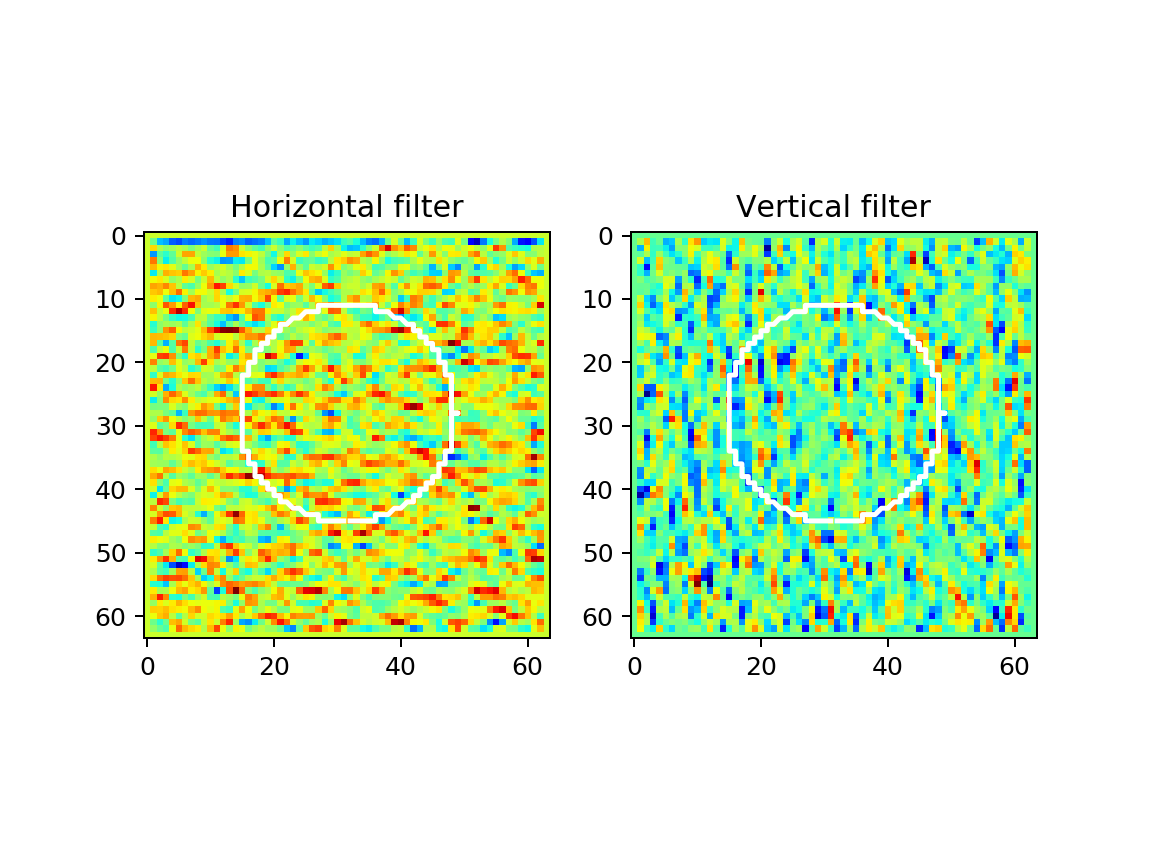

In [29]:
# fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Horizontal filter')
ax2.set_title('Vertical filter')

h1 = ax1.imshow(sh_avg[:,:,0], cmap=plt.cm.jet)
h2 = ax2.imshow(sv_avg[:,:,0], cmap=plt.cm.jet)
ax1.plot(x,y,color='w', linewidth=2.0)
ax2.plot(x,y,color='w', linewidth=2.0)

def init():
    h1.set_data(np.zeros_like(sh_avg[:,:,0]))
    h2.set_data(np.zeros_like(sv_avg[:,:,0]))
    return h1, h2

def animate(i):
    h1.set_data(sh_avg[:,:,i])
    h2.set_data(sv_avg[:,:,i])
    return h1, h2
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=sv_avg.shape[-1])#, interval=20, blit=True)
# anim.save('basic_animation_sobel.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [34]:
from matplotlib import pyplot as plt
from matplotlib import animation

In [35]:
from skimage.filters import roberts
from skimage.filters import sobel
from skimage.filters import prewitt

# Gaussian for image
![gaussian](http://campar.in.tum.de/twiki/pub/Chair/HaukeHeibelGaussianDerivatives/gauss2d00.png)

in this case we wanna make filter that will count the max weight for the center pixel in the mask, in other words it is a simple convolution with max weight in the center of mask. 
![gaussian_explonation](https://www.researchgate.net/profile/Yasuaki_Ito/publication/294424568/figure/fig12/AS:330299767574530@1455761009308/Figure-4-Illustrating-a-window-of-size-m-m-a-Gaussian-filter-of-size-2w-1-2w.png)

In [38]:
img_gaus = np.array(
    map(lambda img: ndimage.gaussian_filter(img, sigma=1., mode='wrap'), img)
)

# Gaussian + Sobel edge detection

brief explonation of sobel filter
![sobel_explonatino](http://people.ece.cornell.edu/land/courses/ece5760/FinalProjects/s2013/cwf38_as889_mao65/images/sobel_convolution.png)

After applying gaussian smoothing process with horisontal and vertical sobel filters for every image in a sequence

<IPython.core.display.Javascript object>


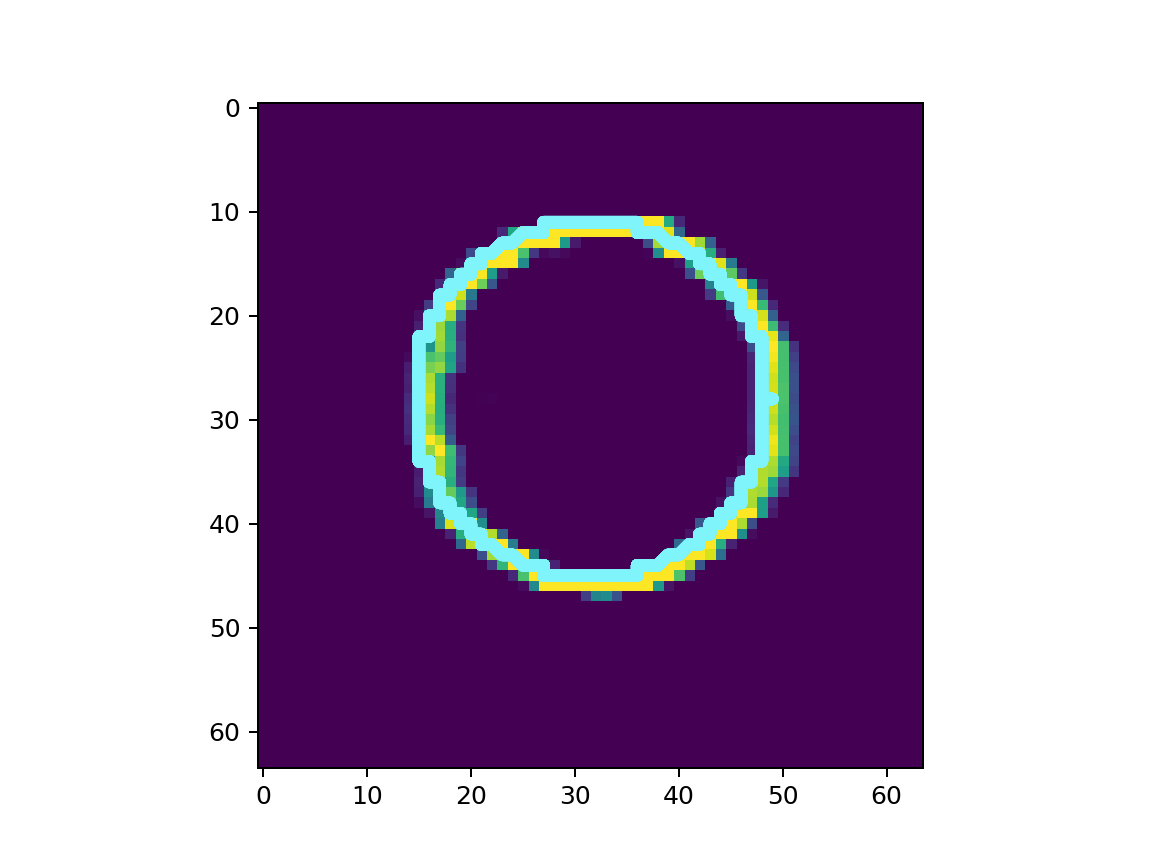

In [37]:
fig = plt.figure()

ax = plt.imshow(img_gaus[:,:,0])


def init():
    ax.set_data(np.zeros_like(img_gaus[:,:,0]))
    return ax,

def animate(i): 
    
    t = 60
    x0, y0 = 32.0, 28.5

    R = 17
    t = np.linspace(0, np.pi * 2, 369)
    x = x0 + R*np.sin(t)
    y = y0 + R*np.cos(t)
    
    x = np.array([int(e) for e in x])
    y = np.array([int(e) for e in y])

    plt.plot(x, y, color='#7ff4fa', linewidth=5.0,)
    image = img_gaus[:,:,i]
    
#     edge_roberts = roberts(image)
    edge_sobel = sobel(image)
    ax.set_data(edge_sobel)

    return ax,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=img.shape[-1])#, interval=20, blit=True)

# anim.save('grad.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

we are estimating the gradient inside the space between provided ROI and actual maximum gradient front

In [40]:
def edge_grad(img, func, kwargs):
    """
    function that makes possible to use any edge detection algorithms
    :param min_R: (max_R - min_R) / separation_count - po for future smoothing
    :param max_R: (max_R - min_R) / separation_count - po for future smoothing
    :separation_count: (max_R - min_R) / separation_count - po for future smoothing
    """
    diff_grad = []
    
    min_boudary = kwargs.get('min_R', 16.7)
    max_boundary = kwargs.get('max_R', 17.3)
    R = (max_boundary + min_boudary) / 2.
    
    separation_count = kwargs.get('separation_count', 10)
    
    x0 = kwargs.get('x0', 32.0)
    y0 = kwargs.get('y0', 28.5)
    t = kwargs.get('t', 60)
    img_count = kwargs.get('img_count', 369)

    for R in np.linspace(min_boudary, max_boundary, separation_count):
        local_diff_grad = []
        for i in range(img_count):
            image = img[:,:, i]
            edge_roberts = func(image)

            t = np.linspace(0, np.pi * 2, img_count)
            x = x0 + R * np.sin(t)
            y = y0 + R * np.cos(t)
    
            local_diff_grad.append([])
            for xl, yl in zip(x, y):
                local_diff_grad[i].append(edge_roberts[int(xl), int(yl)])
            
        diff_grad.append(local_diff_grad)
    diff_grad = np.array(diff_grad).sum(axis=0) / separation_count
    return diff_grad

creating an experiment, assembling all parts of processing pipline together in one method

In [69]:
proc = Processing()

def make_experiment(single_filter, roi_imgs, smooth_func=None, win_func=win_gaus, **kwargs):
    
    """
    full experiment function 
    smooth function -> edge detection filter -> averaging by gaussian
    """
    
    smooth_sigma = kwargs.pop('smooth_sigma', 3)
    if not smooth_func:
        _frames = proc.process_single_filter(roi_imgs, single_filter)
    else:
        
        roi_imgs_smooth = map(lambda img: smooth_func(img, sigma=smooth_sigma), roi_imgs)
        _frames = proc.process_single_filter(
            np.array(roi_imgs_smooth),
            single_filter
        )
        
    n = kwargs.get('n', 5)
    
    av_roi_img = map(lambda ar: win_gaus(ar, **kwargs), [_frames])

#     print np.array(av_roi_img).shape
    return av_roi_img


    
prepared_imgs = make_experiment(
    single_filter=sobel,
    win_func=win_gaus,
    smooth_func=ndimage.gaussian_filter,
    roi_imgs=img,
    n=5,
    smooth_sigma=3,
    sigma=0.4,
    truncate=3
)[0]

np.array(prepared_imgs).shape;


(1, 64, 64, 365)


(64, 64, 365)

Searching for a better fit - an actual ROI border

In [41]:
%%time

diff_grad_sobel = edge_grad(
    img, 
    sobel,
    {
        'min_R': 16.5,
        'max_R': 17.5,
        'separation_count': 20,
        'img_count': img.shape[-1],
        't': 60
    }
)

diff_grad_roberts = edge_grad(
    img, 
    roberts,
    {
        'min_R': 16.7,
        'max_R': 17.4,
        'separation_count': 50,
        'img_count': img.shape[-1],
        't': 60
    }
)

diff_grad_prewitt = edge_grad(
    img, 
    prewitt,
    {
        'min_R': 16.4,
        'max_R': 17.4,
        'separation_count': 30,
        'img_count': img.shape[-1],
        't': 60
    }
)


diff_grad_gaus_sobel = edge_grad(
    img, 
    sobel,
    {
        'min_R': 16.4,
        'max_R': 17.4,
        'separation_count': 30,
        'img_count': img_gaus.shape[-1],
        't': 60
    }
)

assert diff_grad_sobel.shape == (369, 369)
assert diff_grad_roberts.shape == (369, 369)
assert diff_grad_prewitt.shape == (369, 369)

CPU times: user 29.4 s, sys: 585 ms, total: 30 s
Wall time: 30.1 s


In [42]:
# STANDARD ANIMATED PLOT
def standard_plot(diff_grad, save=None):
    fig, ax = plt.subplots()

    x = np.arange(len(diff_grad[0]))
    line, = ax.plot(x, diff_grad[0])


    def animate(i):
        line.set_ydata(diff_grad[i])  # update the data
        return line,


    # Init only required for blitting to give a clean slate.
    def init():
        line.set_ydata(np.ma.array(x, mask=True))
        return line,

    ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                                  interval=25, blit=True)
    if save:
        ani.save(save, fps=30, extra_args=['-vcodec', 'libx264'])
        
    plt.show()

comparing different combinations of filters and smoothing kernels

<IPython.core.display.Javascript object>


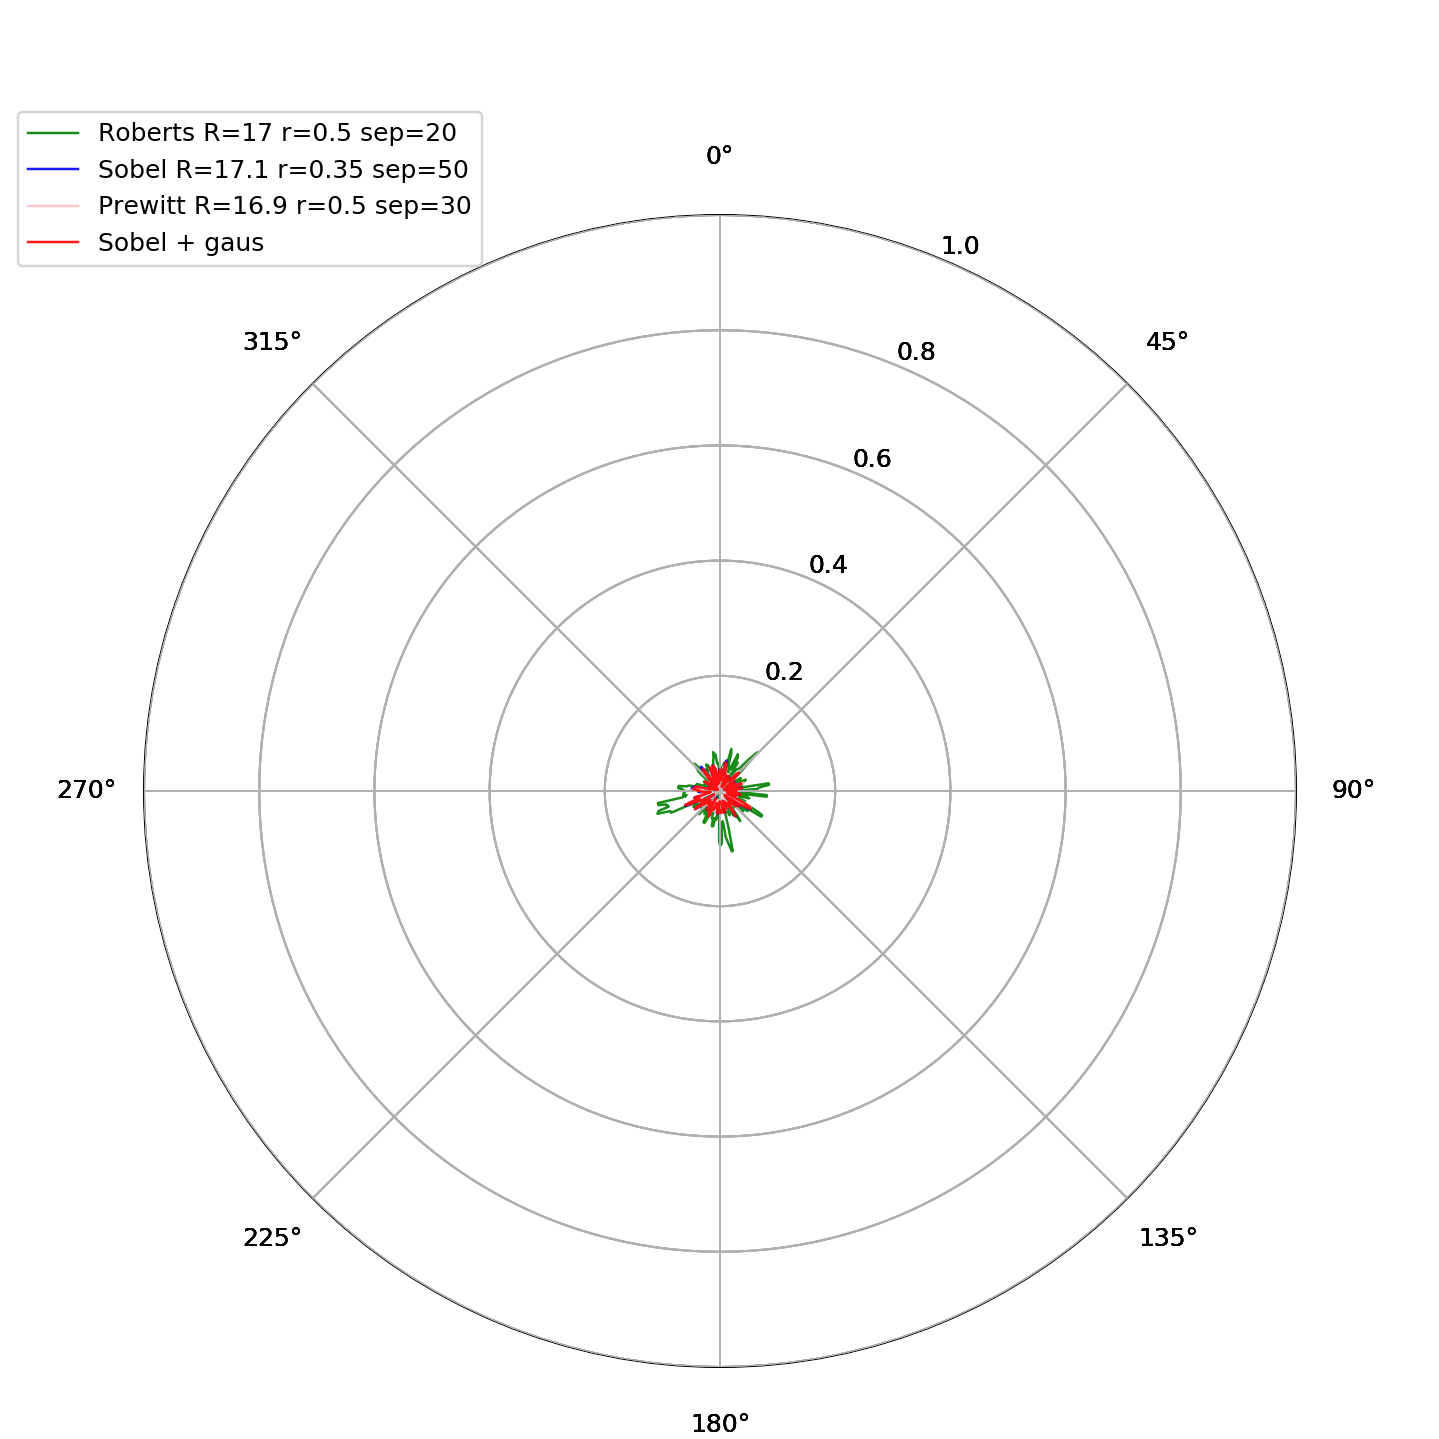

In [45]:
# implementation of visualisation

def data_gen():
    x = np.arange(-180.0,190.0, 370 / img.shape[-1])[:img.shape[-1]]
    theta = (np.pi / 180.0 ) * x    # in radians 
    for i in xrange(img.shape[-1]):
        yield (theta, diff_grad_roberts[i], diff_grad_sobel[i], diff_grad_prewitt[i], diff_grad_gaus_sobel[i])
    
def init():
#     ax.set_ylim(0,1)
    del theta[:]
    del R1[:]
    del R2[:]
    del R3[:]
    del R4[:]
    line.set_data(theta, R1)
    line2.set_data(theta, R2)
    line3.set_data(theta, R3)
    line4.set_data(theta, R4)
    return line, line2, line3, line4,

def polar_twin(ax):
    ax2 = ax.figure.add_axes(
        ax.get_position(), 
        projection='polar', 
        label='twin',
        frameon=False,
        theta_direction=ax.get_theta_direction(),
        theta_offset=ax.get_theta_offset()
    )

    from matplotlib.ticker import MaxNLocator

    ax2.yaxis.set_major_locator(MaxNLocator(nbins=len(ax.get_yticks())))

    ax2.set_ylim(0, ax2.get_yticks()[-1])

    ax2.yaxis.get_major_ticks()[0].label1.set_visible(False)

    return ax2

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([.05, .05, .9, .8], polar=True, theta_direction=-1, theta_offset=np.pi/2)
ax.set_ylim(0, 1)
ax2 = polar_twin(ax)
ax3 = polar_twin(ax)
ax4 = polar_twin(ax)

line, = ax.plot([], [], lw=1, alpha=.9, c='green', label='Roberts R=17 r=0.5 sep=20')
line2, = ax2.plot([], [], lw=1, alpha=.9, c='blue', label='Sobel R=17.1 r=0.35 sep=50')
line3, = ax3.plot([], [], lw=1, alpha=.9, c='pink', label='Prewitt R=16.9 r=0.5 sep=30')
line4, = ax4.plot([], [], lw=1, alpha=0.9, c='red', label='Sobel + gaus')

ax.legend(
    [line, line2, line3, line4,],
    [line.get_label(), line2.get_label(), line3.get_label(), line4.get_label(),],
    loc='upper left', bbox_to_anchor=(-0.12, 1.1)
)
# ax2.legend([line2,], [line2.get_label(),])
# ax3.legend([line3,], [line3.get_label(),])

theta, R1, R2, R3, R4 = [], [], [], [], []

def run(data): 
    theta, R1, R2, R3, R4 = data

    offset = 2.0

    line.set_data(theta, R1)
    line2.set_data(theta, R2)
    line3.set_data(theta, R3)
    line4.set_data(theta, R4)
    
    return line, line2, line3, line4,

anim = animation.FuncAnimation(fig, run, frames=data_gen, init_func=init, blit=True, interval=20, repeat=False)
anim.save('polar_abs_grad_with_gaus.mp4', fps=2, extra_args=['-vcodec', 'libx264'])
# plt.show()

In [5]:
def data_gen():
    x = np.arange(-180.0,190.0, 1.00271)[:369]
    theta = (np.pi / 180.0 ) * x    # in radians 
    for i in xrange(diff_grad.shape[-1]):
        yield (theta, diff_grad_roberts[i])
    
def init():
    ax.set_ylim(0,1)
    del theta[:]
    del R1[:]
    line.set_data(theta, R1)
    return line,

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([.05, .05, .9, .8], polar=True)
ax.set_ylim(0,2)
line, = ax.plot([], [], lw=2)

# ax.grid(1)

theta, R1 = [], []

def run(data): 
    theta, R1 = data

    offset = 2.0

    line.set_data(theta, R1)
    return line,

anim = animation.FuncAnimation(fig, run, frames=data_gen, init_func=init, blit=True, interval=100, repeat=False)
# anim.save('polar_abs_grad.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
# plt.show()



<IPython.core.display.Javascript object>

NameError: name 'animation' is not defined

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
# cut segment after bleaching
# find countour
# apply sobol filter for S_x and S_y
# get atan(S_y/S_x)
# calculate mean for some number of frames show arrow with amplitude in points


In [ ]:
from IPython.display import HTML

In [ ]:
stop_bioformats()